<a href="https://colab.research.google.com/github/hepham/GANS/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time 

# for building GAN
import torch
import torch.nn as nn  
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# for visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import make_grid
%matplotlib inline

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/'
%cd gdrive//MyDrive
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

/content/gdrive/MyDrive
--2021-11-26 00:49:39--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-11-26 00:49:39--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.4’

MNIST.tar.gz.4          [            <=>     ]  33.20M  2.99MB/s    in 11s     

2021-11-26 00:49:50 (2.97 MB/s) - ‘MNIST.tar.gz.4’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-ima

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])
dataset = MNIST(path, train=True, download=True,
                transform = transform)           


Image size: torch.Size([1, 28, 28])
Label: 8


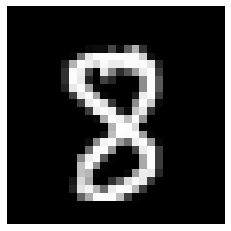

In [ ]:
# Show a random image
idx = np.random.choice(len(dataset)) # get a random index in range [0, len(dataset))
img, label = dataset[idx] 
print('Image size: {}'.format(img.shape))
print('Label: {}'.format(label))
plt.axis('off')
plt.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

In [ ]:

# create a dataloader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def show_images(image_tensor, num_images=25, nrow=5, save=False): 
  image_tensor = image_tensor.detach().to('cpu') 
  # convert the output values to the expected range of float pixel values [0, 1]
  image_tensor = (image_tensor + 1)/2  
  img = make_grid(image_tensor[:num_images], nrow=nrow).permute(1,2,0).squeeze()
  # if save is True, just return the image  
  
  if save:
    return img
  plt.axis('off')
  plt.imshow(img)
  plt.show()

torch.Size([128, 1, 28, 28])


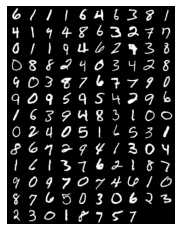

In [ ]:
for i, data in enumerate(dataloader):
  X, _ = data  
  print(X.shape)
  break

show_images(X, 128, 10)

In [ ]:
def noise_vector(num, dim): 
  return torch.randn(num, dim, 1, 1)

In [ ]:
class Generator(nn.Module):
  def __init__(self, zdim, hidden_dim=64, out_channel=1):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # layer 1, input is z (noise)
        self.generator_block(zdim, hidden_dim*4, 4),
        # size (hidden_dim*4) x 4 x 4

        # layer 2
        self.generator_block(hidden_dim*4, hidden_dim*2, 4, 2, 1),        
        # size (hidden_dim*2) x 8 x 8

        # layer 3
        self.generator_block(hidden_dim*2, hidden_dim, 4, 2, 2),                  
        # size (hidden_dim) x 14 x 14

        # layer 4 (last layer)
        self.generator_block(hidden_dim, out_channel, 4, 2, 1, last=True)        
        # output size out_channel x 28 x 28
    )

  def generator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),        
          nn.BatchNorm2d(out_channels),
          nn.ReLU()        
      )
    else:
      gen_block = nn.Sequential(
          nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Tanh()
      )
    return gen_block


  def forward(self, X):
    return self.model(X)

In [ ]:
# apply to Generator and Discriminator network
def init_weights(m):
  if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight, mean=0.0, std=0.02)
  elif type(m) == nn.BatchNorm2d:
    nn.init.normal_(m.weight, mean=0.0, std=0.02)
    nn.init.constant_(m.bias, val=0.0)

In [ ]:
gen = Generator(100)
gen.apply(init_weights)
print(gen)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Tanh()
    )
  )
)


torch.Size([1, 28, 28])


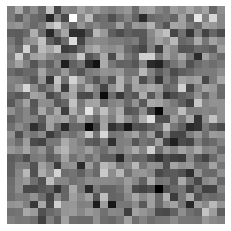

In [ ]:
z = noise_vector(1, 100)
fake = gen(z).detach()
print(fake[0].shape)

plt.axis('off')
plt.imshow(fake[0].permute(1, 2, 0).squeeze(), cmap='gray')
plt.show()

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, im_channel=1, hidden_dim=64):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        # layer 1, input is image of size im_channel x 28 x 28
        self.discriminator_block(im_channel, hidden_dim, 4, 2, 1),        
        # size (hidden_dim) x 14 x 14

        # layer 2
        self.discriminator_block(hidden_dim, hidden_dim*2, 4, 2, 2),        
        # size (hidden_dim*2) x 8 x 8

        # layer 3
        self.discriminator_block(hidden_dim*2, hidden_dim*4, 4, 2, 1),   
        # size (hidden_dim*4) x 4 x 4

        # layer 4 (last layer)
        self.discriminator_block(hidden_dim*4, 1, 4, last=True)  
        # output size 1 (probability)      
    )

  def discriminator_block(self, in_channels, out_channels, kernel_size, stride=1, padding=0, last=False):
    if not last:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(0.2)
      )
    else:
      disc_block = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
          nn.Sigmoid()
      )
    return disc_block
  
  def forward(self, image):
    out = self.model(image)
    return out.view(len(image), -1)

In [ ]:
disc = Discriminator()
disc.apply(init_weights)
print(disc)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)


In [ ]:
# define some important variables

# dimension of noise vector
z_dim = 100

device = "cuda" if torch.cuda.is_available() else "cpu"

# loss function
criterion = nn.BCELoss()

# initialize generator, discriminator, optimizer
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
# randomly initialize the model weights from a normal distribution
gen.apply(init_weights)
disc.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Sigmoid()
    )
  )
)

In [ ]:

# optimizers for both Generator and Discriminator
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
optimG = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
optimD = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2))
fixed_noise = noise_vector(100, z_dim).to(device)

In [ ]:
gen.load_state_dict(torch.load('/content/gdrive/MyDrive/model2/Generator.pt'))
disc.load_state_dict(torch.load('/content/gdrive/MyDrive/model2/Dicriminator.pt'))

<All keys matched successfully>

**Training**
---


Training will involve alternating between training the discriminator and the generator. We'll use our functions real_loss and fake_loss to help us calculate the discriminator losses in all of the following cases.


**Discriminator training**
---


Compute the discriminator loss on real, training images
Generate fake images
Compute the discriminator loss on fake, generated images
Add up real and fake loss
Perform backpropagation + an optimization step to update the discriminator's weights
Generator training
Generate fake images
Compute the discriminator loss on fake images, using flipped labels!
Perform backpropagation + an optimization step to update the generator's weights



In [ ]:
num_epochs = 5

img_list = []
gen_losses = []
disc_losses = []

iter = 0

start_time = time.time()
for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):
    real = data[0].to(device)

    # update discriminator
    optimD.zero_grad()
    noise = noise_vector(len(real), z_dim).to(device)
    fake = gen(noise).detach()
    disc_fake_pred = disc(fake)
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)    
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = disc_fake_loss + disc_real_loss

    # record discrimator loss for later visualization purpose
    disc_losses.append(disc_loss.item())
    # calculate gradients of discriminator
    disc_loss.backward()
    # update optimizer
    optimD.step()
    
    # update generator
    optimG.zero_grad()
    noise2 = noise_vector(len(real), z_dim).to(device)
    fake2 = gen(noise2)
    disc_fake_pred2 = disc(fake2)
    gen_loss = criterion(disc_fake_pred2, torch.ones_like(disc_fake_pred2))

    # record generator loss for later visualization purpose
    gen_losses.append(gen_loss.item())
    # calculate gradients of generator
    gen_loss.backward()
    # updatde optimizer
    optimG.step()

    if iter % 250 == 0 or ((epoch == num_epochs-1) and (i == len(dataloader) - 1)):
      with torch.no_grad():
        fixed_fake = gen(fixed_noise)
        img = show_images(fixed_fake, len(fixed_fake), nrow=10, save=True)        
        img_list.append(img)
    iter+=1
  
  # training status
  print('[{}/{}]\tLoss_D: {:.5f}\tLoss_G: {:.5f}\tD(x): {:.5f}\tD(G(z)): {:.5f}/{:.5f}'.format(epoch+1, num_epochs, disc_loss.item(), gen_loss.item(), disc_real_pred.mean().item(), disc_fake_pred.mean().item(), disc_fake_pred2.mean().item()))

end_time = time.time()
print('Training process done! Time used: {} mins.'.format((end_time - start_time)/60))


[1/5]	Loss_D: 0.60939	Loss_G: 1.53027	D(x): 0.66112	D(G(z)): 0.13587/0.24420
[2/5]	Loss_D: 0.85792	Loss_G: 0.93614	D(x): 0.52372	D(G(z)): 0.12786/0.43637
[3/5]	Loss_D: 0.96386	Loss_G: 0.38569	D(x): 0.45202	D(G(z)): 0.07499/0.70838
[4/5]	Loss_D: 0.46040	Loss_G: 2.10292	D(x): 0.83524	D(G(z)): 0.21962/0.15453
[5/5]	Loss_D: 0.48056	Loss_G: 1.72111	D(x): 0.79896	D(G(z)): 0.19484/0.21607
Training process done! Time used: 70.14958012501398 mins.


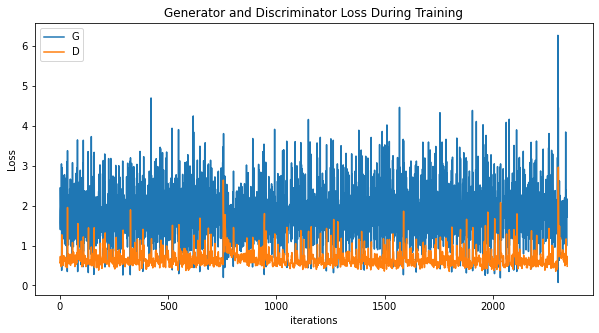

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

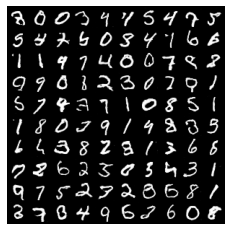

In [ ]:
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=500, blit=True)

HTML(ani.to_html5_video())

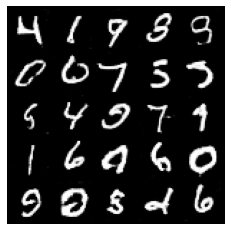

In [ ]:
# noise vector
noise = noise_vector(25, z_dim).to(device)
# pass the noise vectors to trained generator
imgs = gen(noise)
show_images(imgs)

In [ ]:
torch.save(gen.state_dict(), '/content/gdrive/MyDrive/model2/Generator.pt')
torch.save(disc.state_dict(), '/content/gdrive/MyDrive/model2/Dicriminator.pt')